## SSD with pre-trained Inception V3 classifier

- SSD architecture and model weights from tensorflow/object-detection library

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from moviepy.editor import VideoFileClip

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

%matplotlib inline

/home/anand/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/anand/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Render bounding box
- Render bounding box to visualize recognition

In [3]:
def drawBoundingBoxes(image, boxes, color=[255,255,0], thickness = 5):
    h,w,_ = image.shape
    t = thickness // 2
    for box in boxes:
        # scale to image size
        y0,x0,y1,x1 = (box * np.array([h,w,h,w])).astype(np.int32)
        image[ y0-t:y0+t, x0:x1 ] = color
        image[ y1-t:y1+t, x0:x1 ] = color
        image[ y0:y1, x0-t:x0+t ] = color
        image[ y0:y1, x1-t:x1+t ] = color

### Load Model
- Load pre-trained Inception V3 classifier

In [4]:
MODEL='ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Process test images

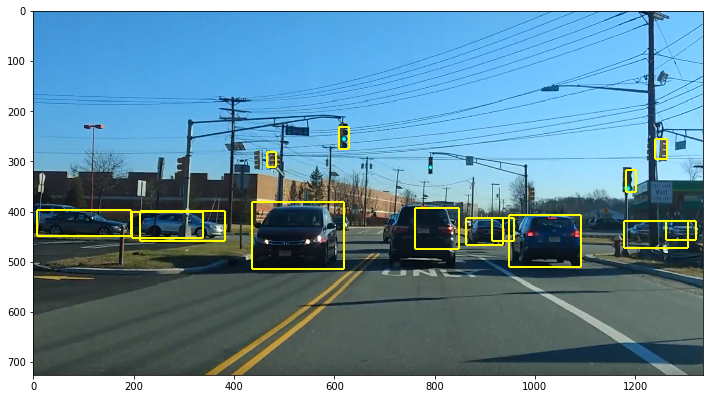

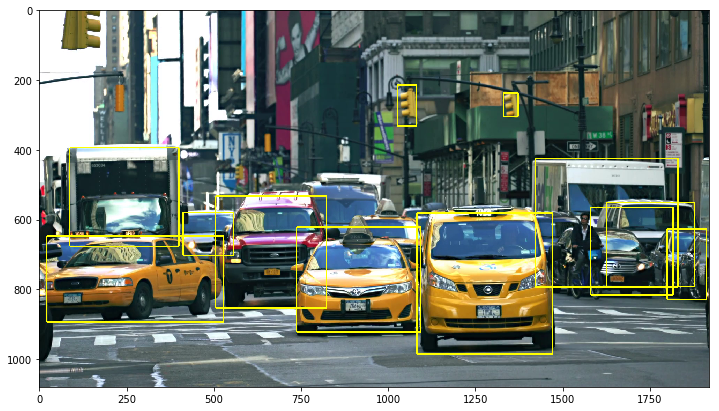

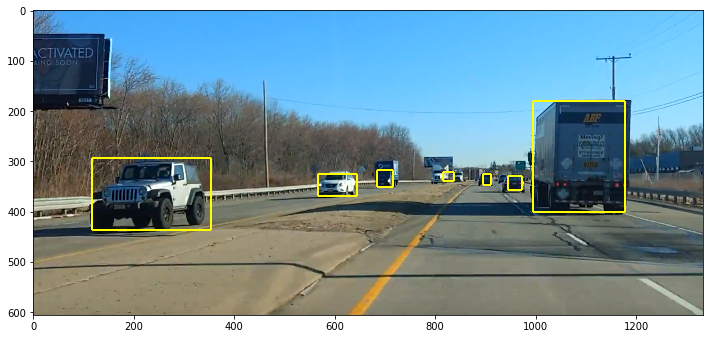

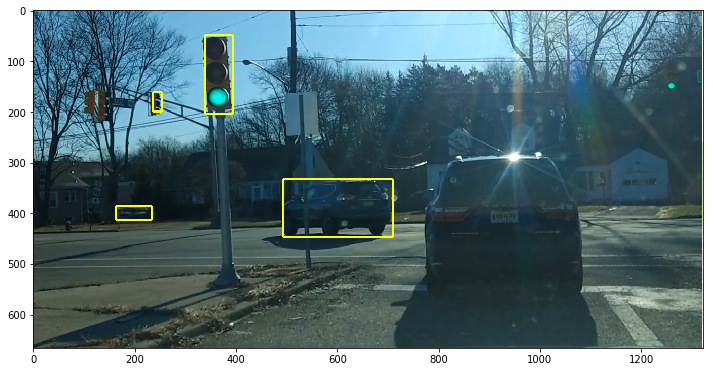

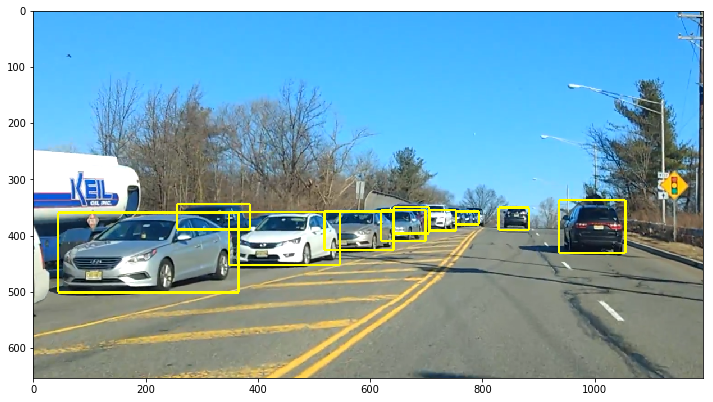

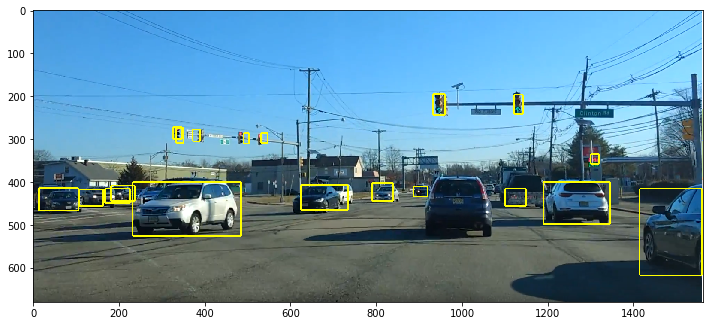

In [5]:
writer = tf.summary.FileWriter("../tblogs", detection_graph)
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in glob.glob('test_images/*.png'):
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            boxes = np.squeeze(boxes)
            classes = np.squeeze(classes)
            scores = np.squeeze(scores)
            
            # Visualization of the results of a detection.
            drawBoundingBoxes(image_np, boxes[scores > 0.3])

            #print("{0} detections\n classes:{1}\n scores:{2}\n boxes:{3}".format(num, classes, scores, boxes))            

            plt.figure(figsize=(12, 8))
            plt.imshow(image_np)
writer.close()

### Run detection on frames

In [ ]:
def processFrame(img):
    global image_tensor, detection_boxes, detection_scores, detection_classes, num_detections
    # 
    img_exp = np.expand_dims(img, axis=0)
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: img_exp})
    
    boxes = np.squeeze(boxes)
    classes = np.squeeze(classes)
    scores = np.squeeze(scores)

    # Render boxes on image
    drawBoundingBoxes(img, boxes[scores > 0.5])
    return image_np

In [ ]:
input_clip = 'VID_20180227_083858981.mp4'
output_clip = 'VID_20180227_083858981.out.mp4'

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        input_video = VideoFileClip(input_clip)
        modifiedClip = input_video.fl_image(processFrame)
        
        %time modifiedClip.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video VID_20180227_083858981.out.mp4
[MoviePy] Writing video VID_20180227_083858981.out.mp4


  7%|▋         | 1419/20375 [01:03<14:11, 22.26it/s]